# Jupyter notebook
## Data cleaning and transformation
Car sales data is scraped from best-selling-cars.com. Over the 14 years analysed the site changed the format of the page url, formatting of the car make and model names, used both lists and tables to present the top ten, and in one year used javascript for the table. This required multiple rounds of scraping, and then cleanup to standardise names. The data is saved to a csv to create an offline copy.

Teslas entered the top ten in the final three years. As electric cars are not comparable to ICE vehicles they have been removed from the data. This does not affect most of the plots which are  weighted averages or emissions per kg. It does affect the bar charts showing sales numbers.

Vehicle specifications for weight and emissions are from two websites which use dropdown menus and requirint some interpretation of model variants, therefore this was collected manually and stored in an xls.

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_palette("plasma")

In [ ]:


#2010

url = "https://www.best-selling-cars.com/britain-uk/2010-britain-best-selling-car-models-in-the-uk/"

response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
ol_element = soup.find('ol')
list_items = ol_element.find_all('li')

data = []
for item in list_items:
    text = item.get_text(strip=True)
    make_model_sold = text.split('…')
    make_model = make_model_sold[0].strip()
    cars_sold = make_model_sold[1].strip()
    
    data.append((make_model, cars_sold, 2010))


#2011
    
url = f"https://www.best-selling-cars.com/britain-uk/2011-full-year-top-ten-best-selling-car-models-in-the-uk/"

response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
ol_element = soup.find('ol')
list_items = ol_element.find_all('li')

for item in list_items:
    text = item.get_text(strip=True)
    make_model_sold = text.split('–')
    make_model = make_model_sold[0].strip()
    cars_sold = make_model_sold[1].strip()
    
    data.append((make_model, cars_sold, 2011))


#2012

url = f"https://www.best-selling-cars.com/britain-uk/2012-full-year-britain-best-selling-car-models-in-the-uk/"

response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
ol_element = soup.find('ol').find('li').find('ol').find('ol')
list_items = ol_element.find_all('li')

for item in list_items:
    text = item.get_text(strip=True)
    make_model_sold = text.split('–')
    make_model = make_model_sold[0].strip()
    cars_sold = make_model_sold[1].strip()
    
    data.append((make_model, cars_sold, 2012))


#2013

url =f"https://www.best-selling-cars.com/britain-uk/2013-full-year-britain-best-selling-car-models-uk/"

response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
table = soup.find('table')
rows = table.find_all('tr')

for row in rows[1:11]:  # Skip the header row
    cols = row.find_all('td')
    brand_model = cols[1].text
    cars_sold = cols[2].text.strip().replace("’", ",")

    data.append((brand_model, cars_sold, 2013))


#2014-16 + 2018

years = list(range(2014, 2017)) + [2018]

for year in (years):

    url =f"https://www.best-selling-cars.com/britain-uk/{year}-full-year-britain-best-selling-car-models/"

    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table')
    rows = table.find_all('tr')

    for row in rows[1:11]:  # Skip the header row
        cols = row.find_all('td')
        brand_model = cols[1].text
        cars_sold = cols[2].text

        data.append((brand_model, cars_sold, str(year)))


#2017
        
driver = webdriver.Firefox()

driver.get("https://www.best-selling-cars.com/britain-uk/2017-full-year-britain-top-ten-best-selling-car-models/")
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')
table = soup.find('table')
rows = table.find_all('tr')


for row in rows[1:11]:
    cols = row.find_all('td')
    brand_model = cols[1].text
    cars_sold = cols[2].text

    data.append((brand_model, cars_sold, 2017))

driver.quit()


#2019-23

years = range(2019, 2024)

for year in (years):
    url =f"https://www.best-selling-cars.com/britain-uk/{year}-full-year-britain-best-selling-car-models-in-the-uk/"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table')
    rows = table.find_all('tr')

    for row in rows[1:11]:
        cols = row.find_all('td')
        brand_model = cols[1].text
        cars_sold = cols[2].text

        data.append((brand_model, cars_sold, str(year)))

#Some of the make and model names are inconsistent across years
corrections = {
    'Mercedes Benz A Class': 'Mercedes-Benz A Class', 'Mercedes-Benz A-Class': 'Mercedes-Benz A Class',
    'Mercedes C Class': 'Mercedes-Benz C Class', 'MINI': 'MINI Mini', 'Mini': 'MINI Mini'}
corrected_data = [(corrections.get(brand_model, brand_model), cars_sold, year) for brand_model, cars_sold, year in data]

#Create df and pivot to correct format for analysis
top_ten_by_year_df = pd.DataFrame(corrected_data, columns = ['model', 'number_sold', 'year'])
pivot_top_ten_by_year_df = top_ten_by_year_df.pivot(index='model', columns='year')
pivot_top_ten_by_year_df.index = pivot_top_ten_by_year_df.index.map(lambda x: ' '.join(x.split()[1:]))
pivot_top_ten_by_year_df.columns = pivot_top_ten_by_year_df.columns.droplevel(0)

#Remove sales figures for Teslas in 2021 and 2022
pivot_top_ten_by_year_df.loc[['Model Y', 'Model 3']] = np.nan

#Change the index label to match rest of code
pivot_top_ten_by_year_df.index.name = 'Model'
pivot_top_ten_by_year_df = pivot_top_ten_by_year_df.apply(lambda x: x.str.replace(',', '').astype('Int64'))
pivot_top_ten_by_year_df.to_csv('sales_data.csv', index_label=None)

## Analysis - weighted average emissions and mass

Average mass of top ten car models by year

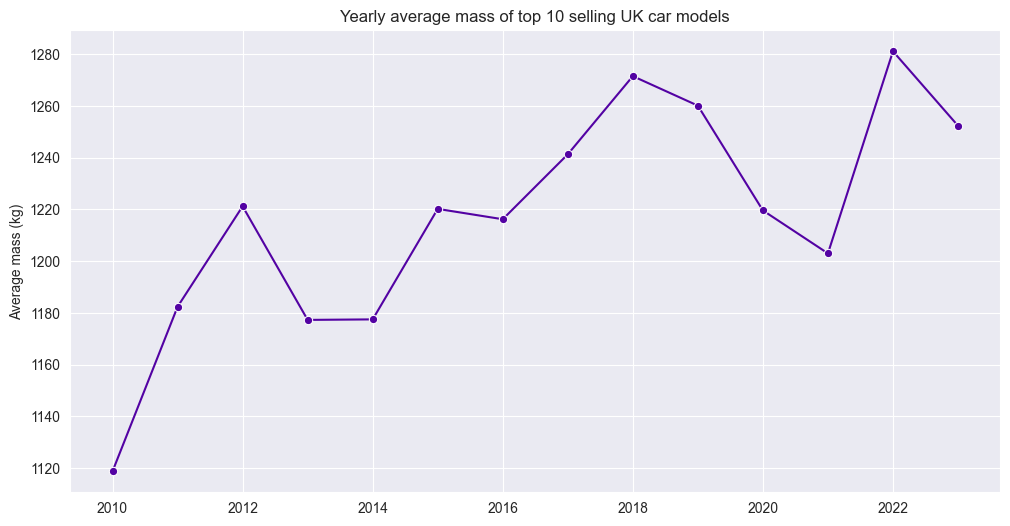

In [2]:

weight_df = pd.read_excel('Car_stats.xlsx', sheet_name='Car weight and CO2')
weight_df['Model']=weight_df['Model'].astype(str)

#Create a dictionary that maps (Model, Year) to Weight
car_weights = {(model, year): weight for model, year, weight in zip(weight_df['Model'], weight_df['Year'], weight_df['Weight kg'])}

sales_df = pd.read_csv('sales_data.csv')

yearly_average_weights = {}

for year in range(2010, 2024):
    total_weight = 0
    total_cars = 0

    for index, row in sales_df.iterrows():
        model = row['Model']

        #Check if the year column has a non-null value
        if not pd.isna(row[str(year)]):
            weight = car_weights.get((model, year))
            total_weight += weight
            total_cars += 1

    if total_cars > 0:
        average_weight = total_weight / total_cars
        yearly_average_weights[year] = average_weight
        

#Create a DataFrame from the dictionary for plotting
average_weight_df = pd.DataFrame(list(yearly_average_weights.items()), columns=['Year', 'Average Weight'])

plt.figure(figsize=(12, 6))
sns.lineplot(data=average_weight_df, x='Year', y='Average Weight', marker='o')
plt.title('Yearly average mass of top 10 selling UK car models')
plt.xlabel('')
plt.ylabel('Average mass (kg)')
plt.grid(True)
plt.show()


Weighted average mass of top ten car models by year

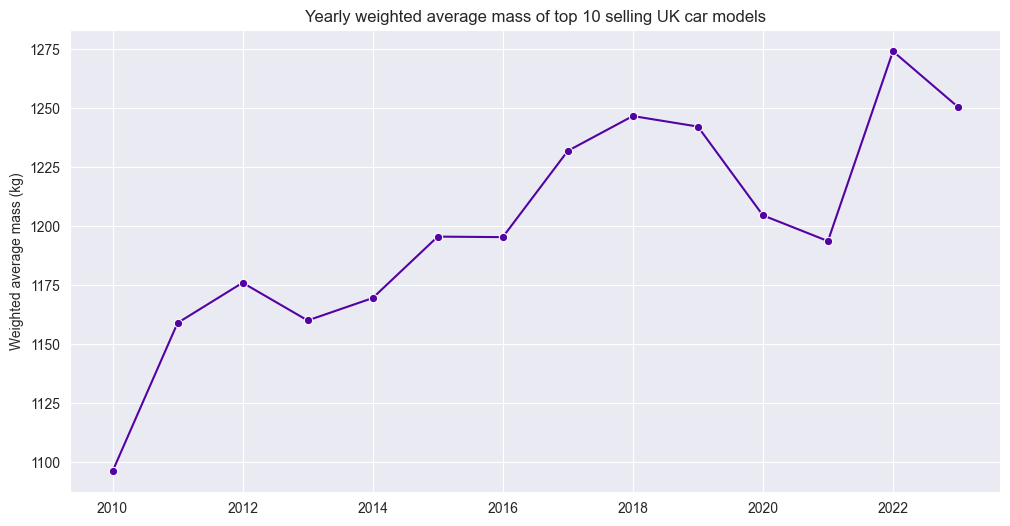

In [12]:

yearly_weighted_averages = {}

for year in range(2010, 2024):
    total_weighted_sum = 0
    total_cars_sold = 0

    for index, row in sales_df.iterrows():
        model = row['Model']

        #Check if the year column has a non-null value
        if not pd.isna(row[str(year)]):
            weight = car_weights.get((model, year), 0)
            cars_sold = row[str(year)] 
            total_weighted_sum += weight * cars_sold
            total_cars_sold += cars_sold

    #Calculate the weighted average weight for the year
    if total_cars_sold > 0:
        weighted_average_weight = total_weighted_sum / total_cars_sold
        yearly_weighted_averages[year] = weighted_average_weight

#Create a DataFrame from the dictionary for plotting
weighted_average_df = pd.DataFrame(list(yearly_weighted_averages.items()), columns=['Year', 'Weighted Average Weight'])

plt.figure(figsize=(12, 6))
sns.lineplot(data=weighted_average_df, x='Year', y='Weighted Average Weight', marker='o')
plt.title('Yearly weighted average mass of top 10 selling UK car models')
plt.xlabel('')
plt.ylabel('Weighted average mass (kg)')
plt.grid(True)
plt.show()


Weighted average mass of top ten car models by year and category (SUV / non-SUV)

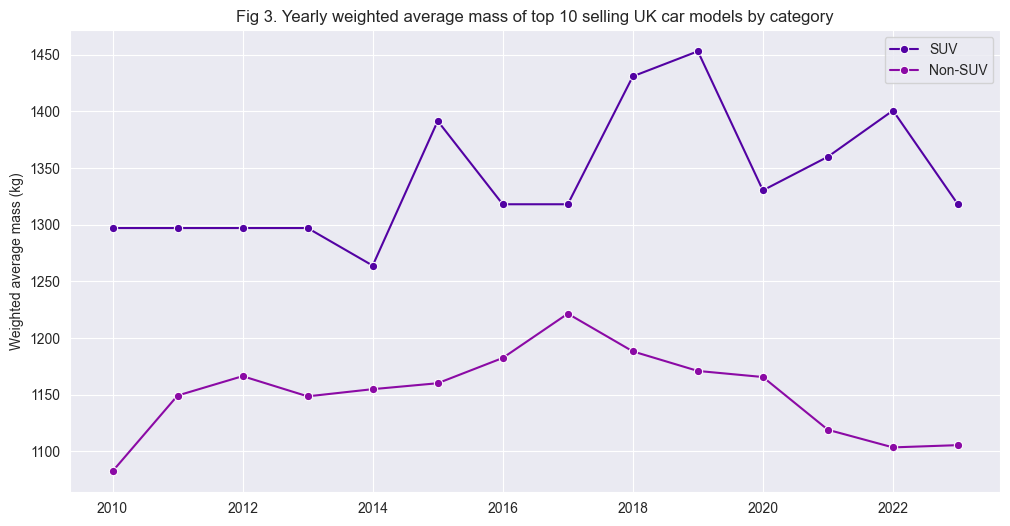

In [31]:
yearly_suv_weighted_averages = {}
yearly_non_suv_weighted_averages = {}

for year in range(2010, 2024):
    total_suv_weighted_sum = 0
    total_non_suv_weighted_sum = 0
    total_suv_cars_sold = 0
    total_non_suv_cars_sold = 0

    for index, row in sales_df.iterrows():
        model = row['Model']

        #Check if the year column has a non-null value
        if not pd.isna(row[str(year)]):
            weight = car_weights.get((model, year), 0)
            cars_sold = row[str(year)]

            matching_entry = weight_df[(weight_df['Model'] == model) & (weight_df['Year'] == year)]
            if not matching_entry.empty:
                is_suv = matching_entry['SUV'].values[0]
                #print('SUV test: ', is_suv)

                if is_suv == 1:
                    total_suv_weighted_sum += weight * cars_sold
                    total_suv_cars_sold += cars_sold
                else:
                    total_non_suv_weighted_sum += weight * cars_sold
                    total_non_suv_cars_sold += cars_sold

    #Calculate the weighted average weight for SUVs and non-SUVs for the year
    if total_suv_cars_sold > 0:
        suv_weighted_average_weight = total_suv_weighted_sum / total_suv_cars_sold
        yearly_suv_weighted_averages[year] = suv_weighted_average_weight

    if total_non_suv_cars_sold > 0:
        non_suv_weighted_average_weight = total_non_suv_weighted_sum / total_non_suv_cars_sold
        yearly_non_suv_weighted_averages[year] = non_suv_weighted_average_weight

#Create DataFrames from the dictionaries for plotting
suv_weighted_average_df = pd.DataFrame(list(yearly_suv_weighted_averages.items()), columns=['Year', 'SUV Weighted Average Weight'])
non_suv_weighted_average_df = pd.DataFrame(list(yearly_non_suv_weighted_averages.items()), columns=['Year', 'Non-SUV Weighted Average Weight'])

plt.figure(figsize=(12, 6))
sns.lineplot(data=suv_weighted_average_df, x='Year', y='SUV Weighted Average Weight', label='SUV', marker='o')
sns.lineplot(data=non_suv_weighted_average_df, x='Year', y='Non-SUV Weighted Average Weight', label='Non-SUV', marker='o')
plt.title('Fig 3. Yearly weighted average mass of top 10 selling UK car models by category')
plt.xlabel('')
plt.ylabel('Weighted average mass (kg)')
plt.legend()
plt.grid(True)
plt.show()


Average CO2 emissions ratings of top ten car models by year

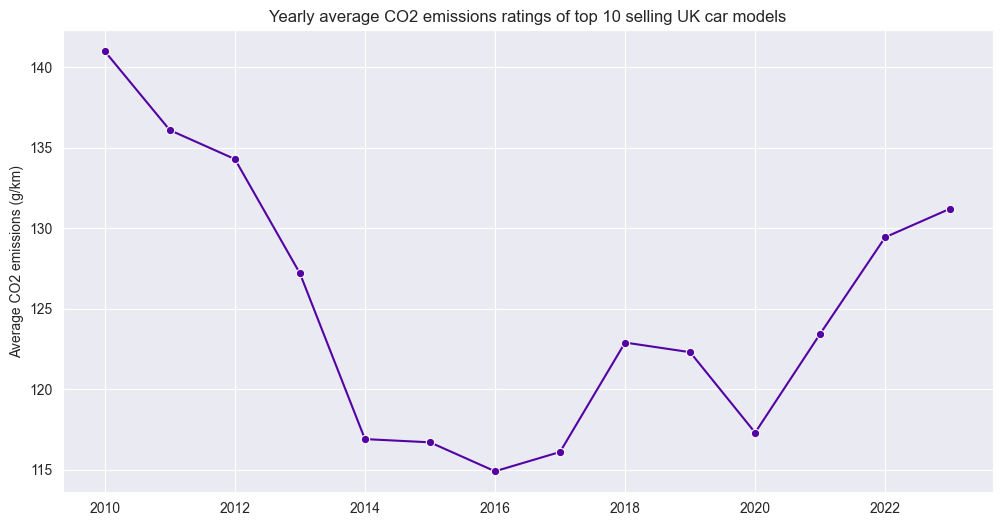

In [18]:
car_co2_emissions = {(model, year): co2 for model, year, co2 in zip(weight_df['Model'], weight_df['Year'], weight_df['CO2'])}

yearly_average_co2_emissions = {}

for year in range(2010, 2024): 
    total_co2_emissions = 0
    total_cars = 0

    for index, row in sales_df.iterrows():
        model = row['Model']

        #Check if the year column has a non-null value
        if not pd.isna(row[str(year)]):
            co2_emissions = car_co2_emissions.get((model, year), 0)
            total_co2_emissions += co2_emissions
            total_cars += 1

    #Calculate the average CO2 emissions for the year
    if total_cars > 0:
        average_co2_emissions = total_co2_emissions / total_cars
        yearly_average_co2_emissions[year] = average_co2_emissions

#Create a DataFrame from the dictionary for plotting
average_co2_df = pd.DataFrame(list(yearly_average_co2_emissions.items()), columns=['Year', 'Average CO2 Emissions'])

plt.figure(figsize=(12, 6))
sns.lineplot(data=average_co2_df, x='Year', y='Average CO2 Emissions', marker='o')
plt.title('Yearly average CO2 emissions ratings of top 10 selling UK car models')
plt.xlabel('')
plt.ylabel('Average CO2 emissions (g/km)')
plt.grid(True)
plt.show()


Weighted average CO2 emissions ratings of top ten car models by year

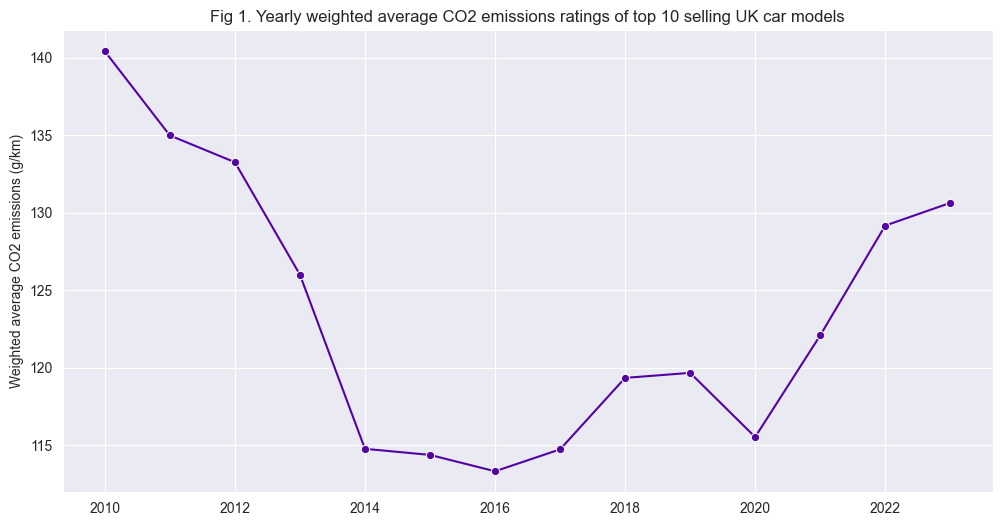

In [29]:

yearly_weighted_averages_co2 = {}

for year in range(2010, 2024):
    total_weighted_co2_emissions = 0
    total_cars_sold = 0

    for index, row in sales_df.iterrows():
        model = row['Model']

        #Check if the year column has a non-null value
        if not pd.isna(row[str(year)]):
            co2_emissions = car_co2_emissions.get((model, year), 0)
            cars_sold = row[str(year)]
            total_weighted_co2_emissions += co2_emissions * cars_sold
            total_cars_sold += cars_sold

    #Calculate the weighted average CO2 emissions for the year
    if total_cars_sold > 0:
        weighted_average_co2_emissions = total_weighted_co2_emissions / total_cars_sold
        yearly_weighted_averages_co2[year] = weighted_average_co2_emissions

#Create a DataFrame from the dictionary for plotting
weighted_average_co2_df = pd.DataFrame(list(yearly_weighted_averages_co2.items()), columns=['Year', 'Weighted Average CO2 Emissions'])

plt.figure(figsize=(12, 6))
sns.lineplot(data=weighted_average_co2_df, x='Year', y='Weighted Average CO2 Emissions', marker='o')
plt.title('Fig 1. Yearly weighted average CO2 emissions ratings of top 10 selling UK car models')
plt.xlabel('')
plt.ylabel('Weighted average CO2 emissions (g/km)')
plt.grid(True)
plt.show()


Weighted average CO2 emissions ratings of top ten car models by year and category (SUV / non-SUV)

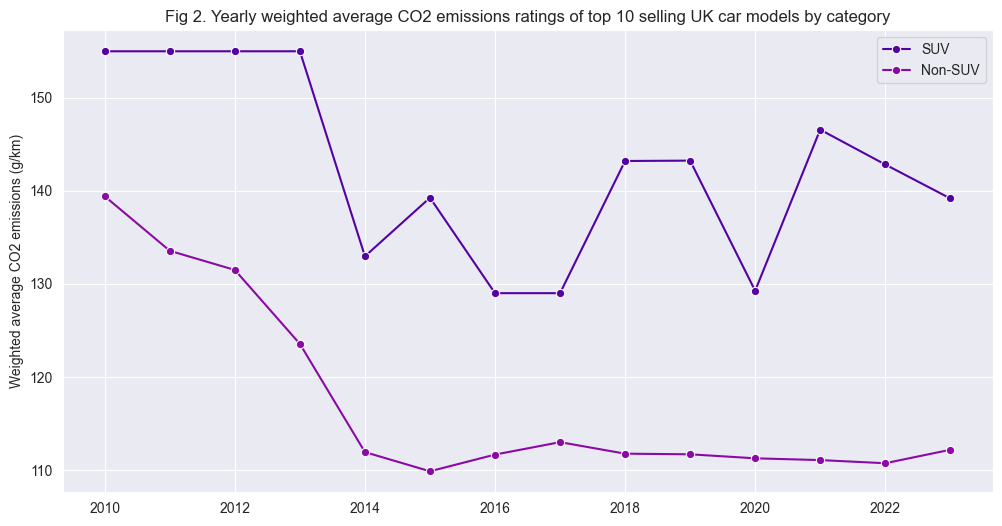

In [30]:

yearly_weighted_averages_suv = {}
yearly_weighted_averages_non_suv = {}


for year in range(2010, 2024):
    total_weighted_co2_emissions_suv = 0
    total_cars_sold_suv = 0
    total_weighted_co2_emissions_non_suv = 0
    total_cars_sold_non_suv = 0

    for index, row in sales_df.iterrows():
        model = row['Model']

        #Check if the year column has a non-null value
        if not pd.isna(row[str(year)]):
            co2_emissions = car_co2_emissions.get((model, year), 0)
            cars_sold = row[str(year)] 
            
            matching_entry = weight_df[(weight_df['Model'] == model) & (weight_df['Year'] == year)]
            if not matching_entry.empty:
                is_suv = matching_entry['SUV'].values[0]

                if is_suv == 1:
                    total_weighted_co2_emissions_suv += co2_emissions * cars_sold
                    total_cars_sold_suv += cars_sold
                else:
                    total_weighted_co2_emissions_non_suv += co2_emissions * cars_sold
                    total_cars_sold_non_suv += cars_sold

    #Calculate the weighted average CO2 emissions for SUVs and non-SUVs for the year
    if total_cars_sold_suv > 0:
        weighted_average_co2_emissions_suv = total_weighted_co2_emissions_suv / total_cars_sold_suv
        yearly_weighted_averages_suv[year] = weighted_average_co2_emissions_suv

    if total_cars_sold_non_suv > 0:
        weighted_average_co2_emissions_non_suv = total_weighted_co2_emissions_non_suv / total_cars_sold_non_suv
        yearly_weighted_averages_non_suv[year] = weighted_average_co2_emissions_non_suv

#Create DataFrames from the dictionaries for plotting
weighted_average_co2_df_suv = pd.DataFrame(list(yearly_weighted_averages_suv.items()), columns=['Year', 'SUV Weighted Average CO2 Emissions'])
weighted_average_co2_df_non_suv = pd.DataFrame(list(yearly_weighted_averages_non_suv.items()), columns=['Year', 'Non-SUV Weighted Average CO2 Emissions'])


plt.figure(figsize=(12, 6))
sns.lineplot(data=weighted_average_co2_df_suv, x='Year', y='SUV Weighted Average CO2 Emissions', label='SUV', marker='o')
sns.lineplot(data=weighted_average_co2_df_non_suv, x='Year', y='Non-SUV Weighted Average CO2 Emissions', label='Non-SUV', marker='o')
plt.title('Fig 2. Yearly weighted average CO2 emissions ratings of top 10 selling UK car models by category')
plt.xlabel('')
plt.ylabel('Weighted average CO2 emissions (g/km)')
plt.legend()
plt.grid(True)
plt.show()


Weighted average mass of top ten car models by year and category (SUV / non-SUV)

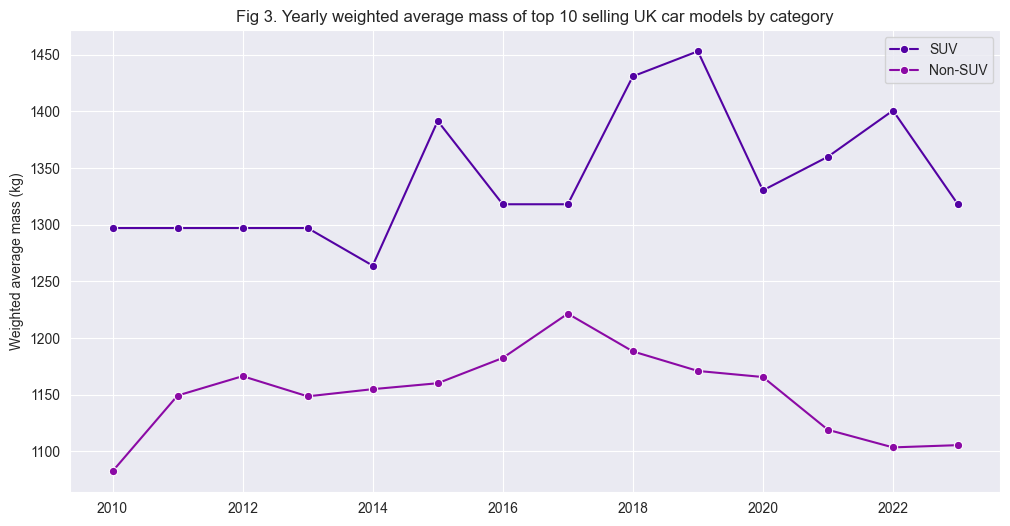

In [38]:

yearly_suv_weighted_averages = {}
yearly_non_suv_weighted_averages = {}

for year in range(2010, 2024):
    total_suv_weighted_sum = 0
    total_non_suv_weighted_sum = 0
    total_suv_cars_sold = 0
    total_non_suv_cars_sold = 0

    for index, row in sales_df.iterrows():
        model = row['Model']

        #Check if the year column has a non-null value
        if not pd.isna(row[str(year)]):
            weight = car_weights.get((model, year), 0)
            cars_sold = row[str(year)]

            matching_entry = weight_df[(weight_df['Model'] == model) & (weight_df['Year'] == year)]
            if not matching_entry.empty:
                is_suv = matching_entry['SUV'].values[0]
                #print('SUV test: ', is_suv)

                if is_suv == 1:
                    total_suv_weighted_sum += weight * cars_sold
                    total_suv_cars_sold += cars_sold
                else:
                    total_non_suv_weighted_sum += weight * cars_sold
                    total_non_suv_cars_sold += cars_sold

    #Calculate the weighted average weight for SUVs and non-SUVs for the year
    if total_suv_cars_sold > 0:
        suv_weighted_average_weight = total_suv_weighted_sum / total_suv_cars_sold
        yearly_suv_weighted_averages[year] = suv_weighted_average_weight

    if total_non_suv_cars_sold > 0:
        non_suv_weighted_average_weight = total_non_suv_weighted_sum / total_non_suv_cars_sold
        yearly_non_suv_weighted_averages[year] = non_suv_weighted_average_weight

#Create DataFrames from the dictionaries for plotting
suv_weighted_average_df = pd.DataFrame(list(yearly_suv_weighted_averages.items()), columns=['Year', 'SUV Weighted Average Weight'])
non_suv_weighted_average_df = pd.DataFrame(list(yearly_non_suv_weighted_averages.items()), columns=['Year', 'Non-SUV Weighted Average Weight'])

plt.figure(figsize=(12, 6))
sns.lineplot(data=suv_weighted_average_df, x='Year', y='SUV Weighted Average Weight', label='SUV', marker='o')
sns.lineplot(data=non_suv_weighted_average_df, x='Year', y='Non-SUV Weighted Average Weight', label='Non-SUV', marker='o')
plt.title('Fig 3. Yearly weighted average mass of top 10 selling UK car models by category')
plt.xlabel('')
plt.ylabel('Weighted average mass (kg)')
plt.legend()
plt.grid(True)
plt.show()


CO2 emissions per kg of top ten car models by year and category (SUV / non-SUV)

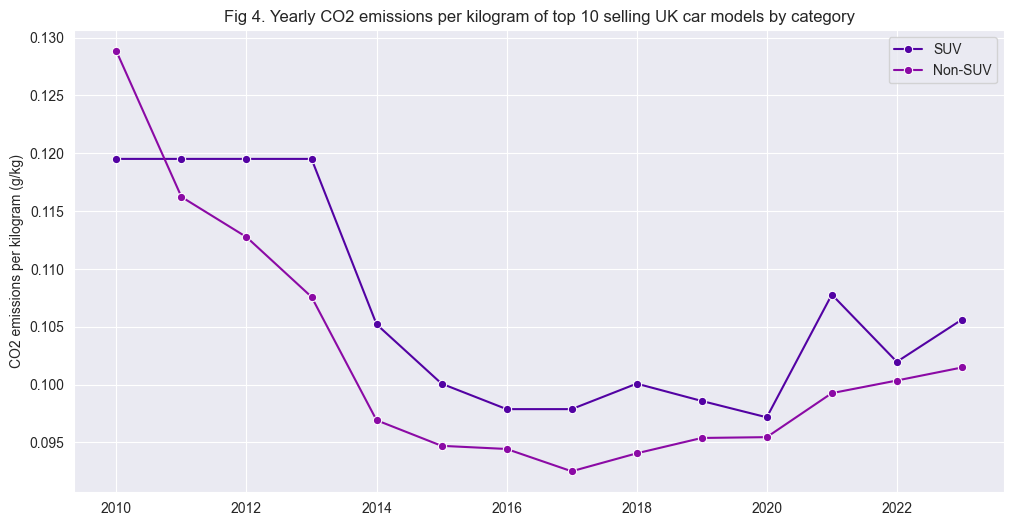

In [32]:

yearly_suv_co2_per_kg = {}
yearly_non_suv_co2_per_kg = {}

for year in range(2010, 2024):
    total_suv_co2_sum = 0
    total_non_suv_co2_sum = 0
    total_suv_weight_sum = 0
    total_non_suv_weight_sum = 0

    for index, row in sales_df.iterrows():
        model = row['Model']

        #Check if the year column has a non-null value
        if not pd.isna(row[str(year)]):
            weight = car_weights.get((model, year), 0)
            cars_sold = row[str(year)] 

            matching_entry = weight_df[(weight_df['Model'] == model) & (weight_df['Year'] == year)]
            if not matching_entry.empty:
                is_suv = matching_entry['SUV'].values[0]
                co2_emission = matching_entry['CO2'].values[0]  

                if is_suv == 1:
                    total_suv_co2_sum += co2_emission * cars_sold
                    total_suv_weight_sum += weight * cars_sold
                else:
                    total_non_suv_co2_sum += co2_emission * cars_sold
                    total_non_suv_weight_sum += weight * cars_sold

    #Calculate CO2 emissions per kilogram for SUVs and non-SUVs for the year
    if total_suv_weight_sum > 0:
        suv_co2_per_kg = total_suv_co2_sum / total_suv_weight_sum
        yearly_suv_co2_per_kg[year] = suv_co2_per_kg

    if total_non_suv_weight_sum > 0:
        non_suv_co2_per_kg = total_non_suv_co2_sum / total_non_suv_weight_sum
        yearly_non_suv_co2_per_kg[year] = non_suv_co2_per_kg

#Create DataFrames from the dictionaries for plotting
suv_co2_per_kg_df = pd.DataFrame(list(yearly_suv_co2_per_kg.items()), columns=['Year', 'SUV CO2 per kg'])
non_suv_co2_per_kg_df = pd.DataFrame(list(yearly_non_suv_co2_per_kg.items()), columns=['Year', 'Non-SUV CO2 per kg'])

plt.figure(figsize=(12, 6))
sns.lineplot(data=suv_co2_per_kg_df, x='Year', y='SUV CO2 per kg', label='SUV', marker='o')
sns.lineplot(data=non_suv_co2_per_kg_df, x='Year', y='Non-SUV CO2 per kg', label='Non-SUV', marker='o')
plt.title('Fig 4. Yearly CO2 emissions per kilogram of top 10 selling UK car models by category')
plt.xlabel('')
plt.ylabel('CO2 emissions per kilogram (g/kg)')
plt.legend()
plt.grid(True)
plt.show()


Sales of top ten car models by year and category (SUV / non-SUV)

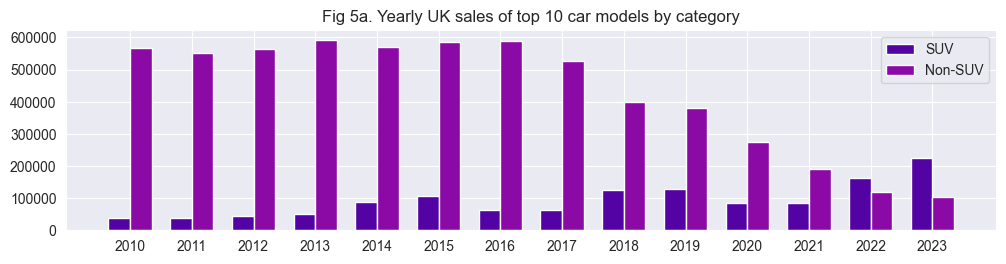

In [33]:

yearly_suv_sales = {}
yearly_non_suv_sales = {}


for year in range(2010, 2024):
    suv_cars_sold = 0
    non_suv_cars_sold = 0

    for index, row in sales_df.iterrows():
        #Check if the year column has a non-null value
        if not pd.isna(row[str(year)]):
            model = row['Model']

            matching_entries = weight_df[(weight_df['Model'] == model) & (weight_df['Year'] == year)]

            if not matching_entries.empty:
                is_suv = matching_entries['SUV'].values[0]

                if is_suv == 1:
                    suv_cars_sold += row[str(year)]
                else:
                    non_suv_cars_sold += row[str(year)]

    yearly_suv_sales[year] = suv_cars_sold
    yearly_non_suv_sales[year] = non_suv_cars_sold

#Create DataFrames from the dictionaries for plotting
suv_sales_df = pd.DataFrame(list(yearly_suv_sales.items()), columns=['Year', 'SUV Sales'])
non_suv_sales_df = pd.DataFrame(list(yearly_non_suv_sales.items()), columns=['Year', 'Non-SUV Sales'])

plt.figure(figsize=(12, 2.6))
bar_width = 0.35
index = range(len(suv_sales_df['Year']))
plt.bar(index, suv_sales_df['SUV Sales'], width=bar_width, label='SUV')
plt.bar([i + bar_width for i in index], non_suv_sales_df['Non-SUV Sales'], width=bar_width, label='Non-SUV')
#plt.xlabel('Year')
plt.xticks([i + bar_width / 2 for i in index], suv_sales_df['Year'])


plt.title('Fig 5a. Yearly UK sales of top 10 car models by category')
#plt.ylabel('Number of cars sold')
plt.legend()
plt.grid(True)
plt.show()

Number of SUV and non-SUV models in top 10 by year

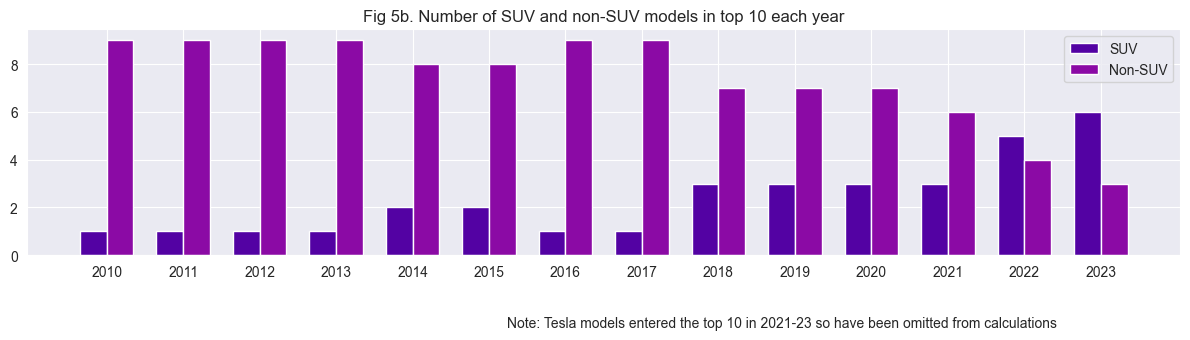

In [34]:

suv_model_counts = []
non_suv_model_counts = []

for year in range(2010, 2024):
    suv_models = set()
    non_suv_models = set()

    for index, row in sales_df.iterrows():
        model = row['Model']

             #Check if the year column has a non-null value
        if not pd.isna(row[str(year)]):
            co2_emissions = car_co2_emissions.get((model, year), 0)
            cars_sold = row[str(year)]

            #Check if there is a matching entry in weight_df
            matching_entry = weight_df[(weight_df['Model'] == model) & (weight_df['Year'] == year)]
            if not matching_entry.empty:
                is_suv = matching_entry['SUV'].values[0]
            
                if is_suv == 1:
                    suv_models.add(model)
                else:
                    non_suv_models.add(model)
                #print('SUVs: ', suv_models, 'Non-SUVs: ', non_suv_models)

    suv_model_counts.append(len(suv_models))
    non_suv_model_counts.append(len(non_suv_models))


plt.figure(figsize=(12, 3))
bar_width = 0.35
index = range(len(range(2010, 2024)))

plt.bar(index, suv_model_counts, bar_width, label='SUV')
plt.bar([i + bar_width for i in index], non_suv_model_counts, bar_width, label='Non-SUV')

#plt.xlabel('Year')
#plt.ylabel('Number of Models')
plt.title('Fig 5b. Number of SUV and non-SUV models in top 10 each year')
plt.xticks([i + bar_width / 2 for i in index], range(2010, 2024))
plt.legend()
plt.tight_layout()
plt.text(9, -3, 'Note: Tesla models entered the top 10 in 2021-23 so have been omitted from calculations', fontsize=10, ha='center')

plt.show()
